In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile 
from zipfile import ZipFile 



# opening the zip file in READ mode 
file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    
    
# import
df_zip = zipfile.ZipFile(file_name)
train = pd.read_csv(df_zip.open('train.csv'))
test = pd.read_csv(df_zip.open('test.csv'))
sample_submission = pd.read_csv(df_zip.open('sample_submission.csv')) 

File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


# EDA

## Dataset summary

In [2]:
train.info()

len(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


11504798

## Sample EDA

Since the dataset is extremely large (11~ million rows), let's do some preliminary EDA on a subset. 

In [3]:


import random

n = len(train) # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))   
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows = skip)
train_sample


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,21,Male,34,1,46.0,1,< 1 Year,No,29698.0,152.0,185,0
1,28,Male,40,1,35.0,0,1-2 Year,Yes,2630.0,157.0,204,1
2,46,Female,47,1,7.0,1,1-2 Year,No,2630.0,124.0,92,0
3,67,Male,43,1,28.0,0,1-2 Year,No,67936.0,26.0,298,0
4,78,Male,46,1,50.0,0,> 2 Years,Yes,31240.0,124.0,132,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504726,Female,36,1,3.0,0,1-2 Year,Yes,18090.0,124.0,159,1
1150475,11504745,Female,28,1,2.0,0,< 1 Year,Yes,2630.0,160.0,271,0
1150476,11504746,Male,55,1,45.0,1,1-2 Year,No,2630.0,29.0,35,0
1150477,11504760,Male,24,1,8.0,1,< 1 Year,No,43309.0,152.0,172,0



### Columns, values

In [4]:
train_sample.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,21,Male,34,1,46.0,1,< 1 Year,No,29698.0,152.0,185,0
1,28,Male,40,1,35.0,0,1-2 Year,Yes,2630.0,157.0,204,1
2,46,Female,47,1,7.0,1,1-2 Year,No,2630.0,124.0,92,0
3,67,Male,43,1,28.0,0,1-2 Year,No,67936.0,26.0,298,0
4,78,Male,46,1,50.0,0,> 2 Years,Yes,31240.0,124.0,132,0
5,89,Female,24,1,14.0,1,< 1 Year,No,46798.0,152.0,101,0
6,95,Male,24,1,8.0,1,< 1 Year,No,48244.0,152.0,262,0
7,102,Male,35,1,18.0,0,1-2 Year,Yes,27150.0,154.0,29,0
8,104,Female,25,1,41.0,1,< 1 Year,No,25998.0,152.0,77,0
9,112,Female,49,1,18.0,0,1-2 Year,Yes,2630.0,26.0,81,0



Based on this output we can further categorize our columns.
- Categorical multi: Region code, Vehicle Age, Policy Sales Channel
- Categorical binary: Gender, Vehicle Age

I suspect Driving License and Vintage are categorical too so let's see what values there are.

In [5]:
train_sample["Driving_License"].value_counts()

1    1148161
0       2318
Name: Driving_License, dtype: int64

In [6]:
train_sample["Vintage"].value_counts()

187    9849
282    9547
131    9126
256    9045
232    8452
       ... 
61     1694
26     1660
32     1538
41     1522
50     1391
Name: Vintage, Length: 290, dtype: int64


There's enough integers for me to think it represents an actual meaningful interval scale. Since the dataset is based on car insurance, this could be some value attached to insurance for vintage/collector cars. It looks like driving license just represents a binary yes/no so we can leave it for now. 

### Row independence


In [7]:
train_sample["id"].value_counts().sort_values( ascending = False).head(10)

21     1
116    1
78     1
89     1
95     1
102    1
323    1
104    1
159    1
46     1
Name: id, dtype: int64


From our sample of ~1 million rows, we don't see duplicates. While it's good practice to check across the whole dataset, I'm aware this is a fairly curated dataset so it should be safe to say the data points are independent person-wise. 

## Univariate visualization

### y - Response

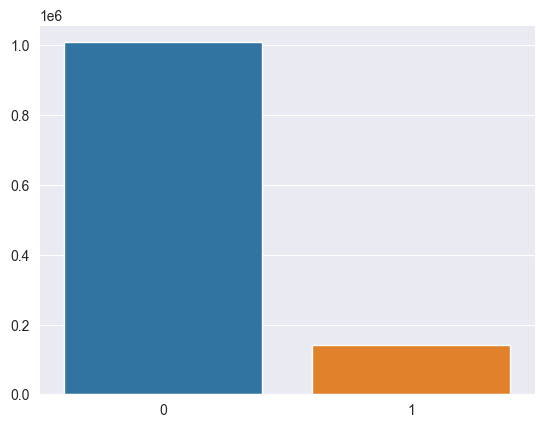

In [8]:

y_counts = train_sample.Response.value_counts()
fig_exit = sns.barplot(x = y_counts.index, y = y_counts.values)
y_counts
train_sample.Response.value_counts(normalize = True)
plt.show()
plt.close("all")



In our sample the cross-sell rate is fairly low as an outcome, ~12%. We'll stratify when we do our train-test split. 


### Categorical

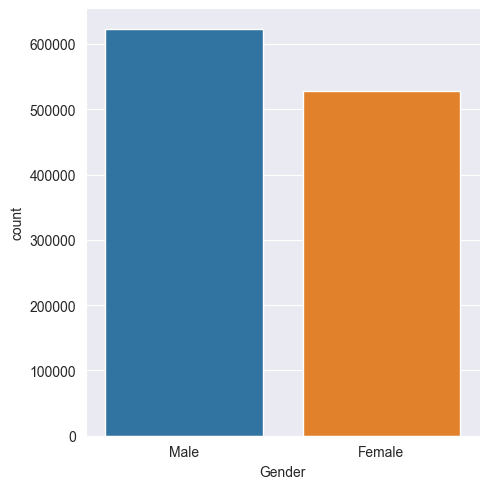

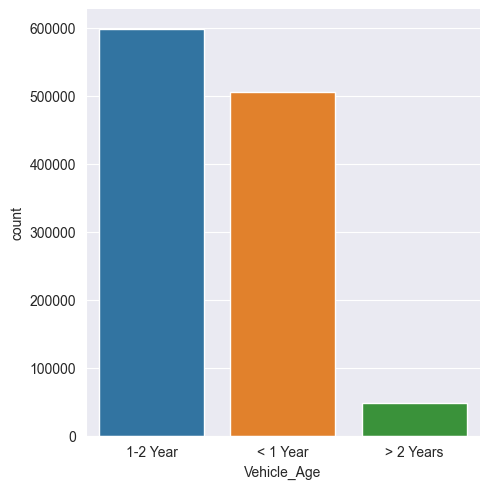

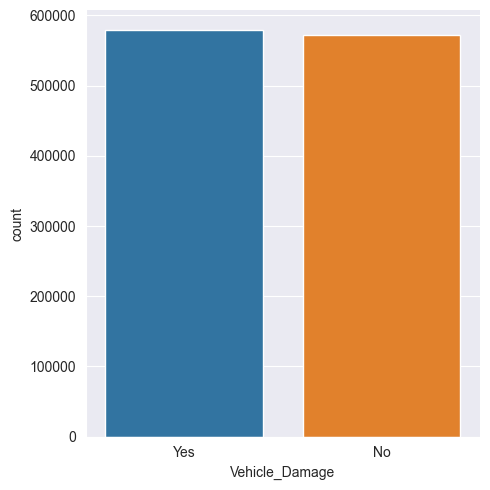

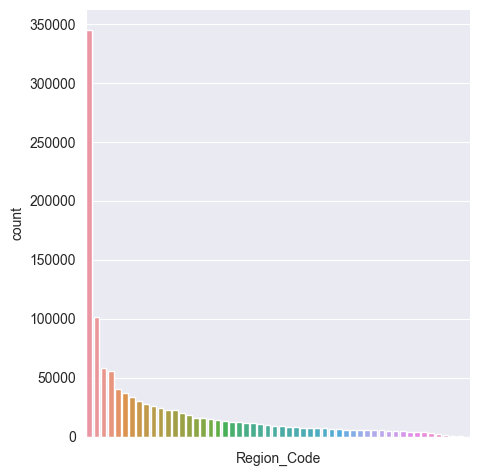

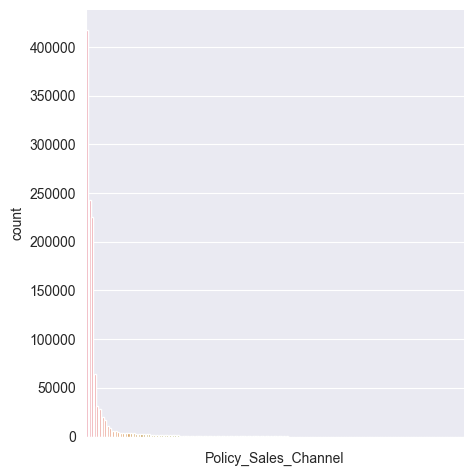

In [9]:
strings = ['object']
string_df = train_sample.select_dtypes(include = strings)
other_cat = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype("category")
cat_df = pd.concat([string_df,other_cat] , axis = 1)

for col in cat_df.columns:
  cat_desc = sns.catplot(x = col, data = cat_df, kind = "count",
                          order = cat_df[col].value_counts().index)
  if col in ["Region_Code", "Policy_Sales_Channel"]:
    # plt.xticks(rotation=90)
    cat_desc.set(xticklabels = [])
  plt.show()
  plt.close("all")

### Numerical

#### Univariate 

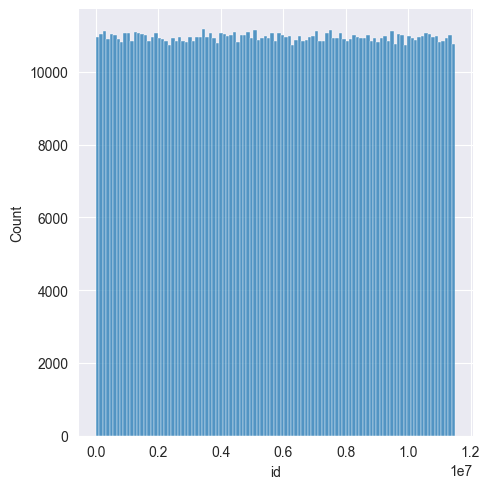

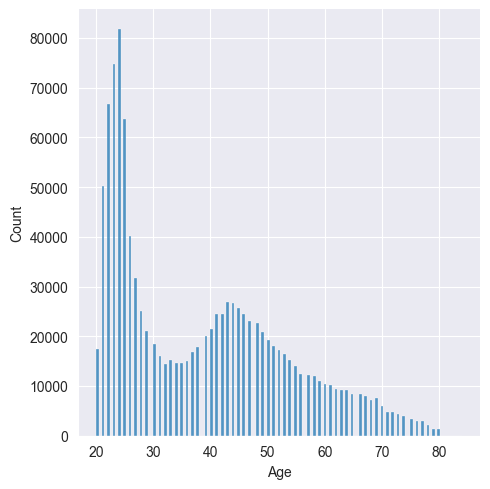

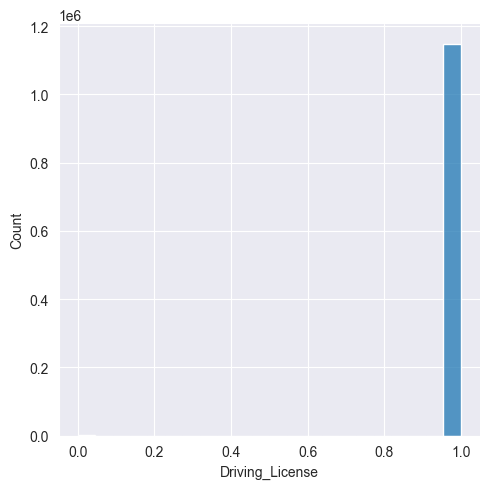

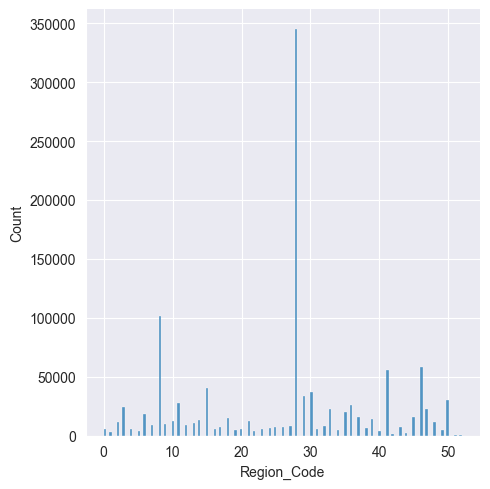

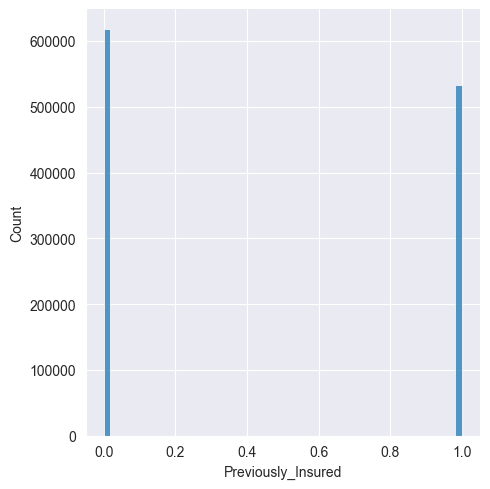

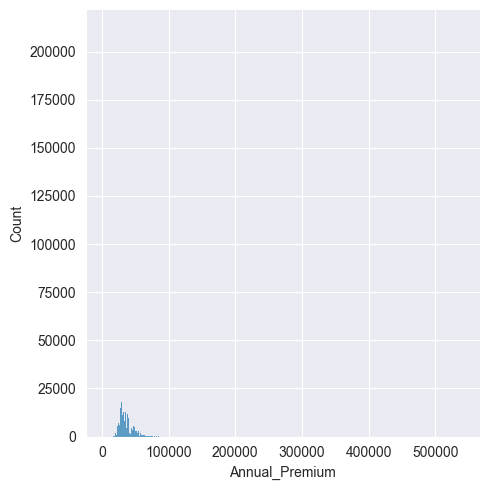

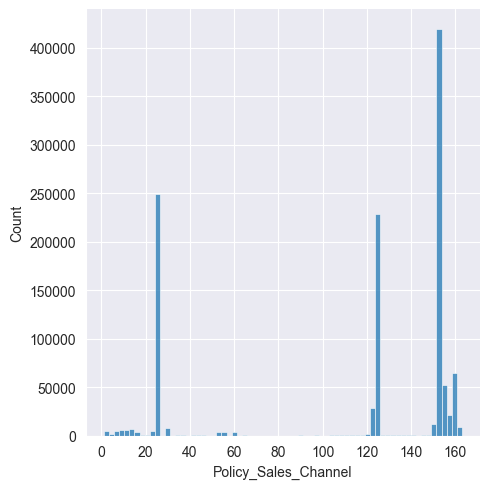

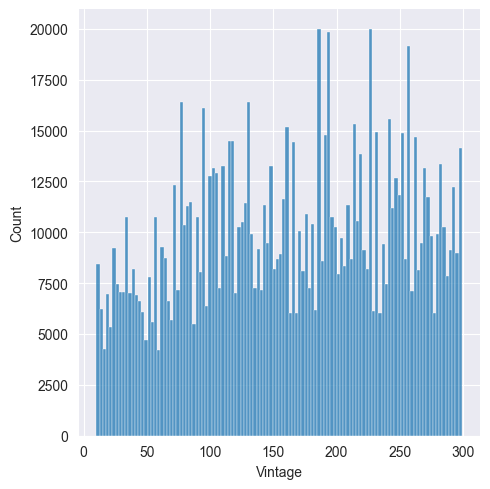

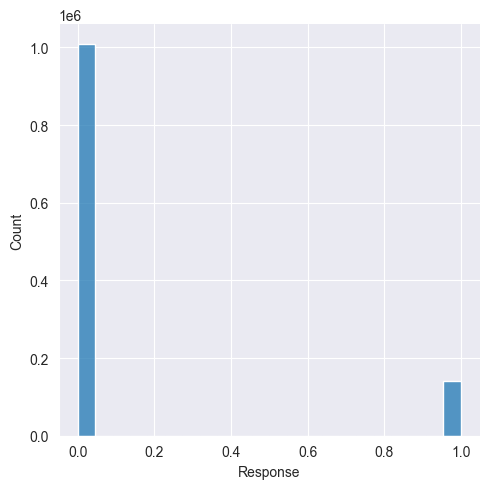

In [10]:
from seaborn import histplot
numeric_df = train_sample.select_dtypes(include = "number")

for col in numeric_df.columns:
  sns.displot(numeric_df, x=col)
  plt.show()
  plt.close("all")



Several observations can be made here:
1. Driver license is heavily imbalanced (mostly licensed)
2. Certain regions are more popular
3. Age distribution has two peaks, mid 20s and mid 40s. 
4. Policy sales mostly come from 3 sources
5. Annual premium is very zoomed out. There's likely outlier(s) on the top end

As a first pass-through we'll run the model(s) with these observations baked in. We note them here as possible avenues for model improvement later.

#### Heat map

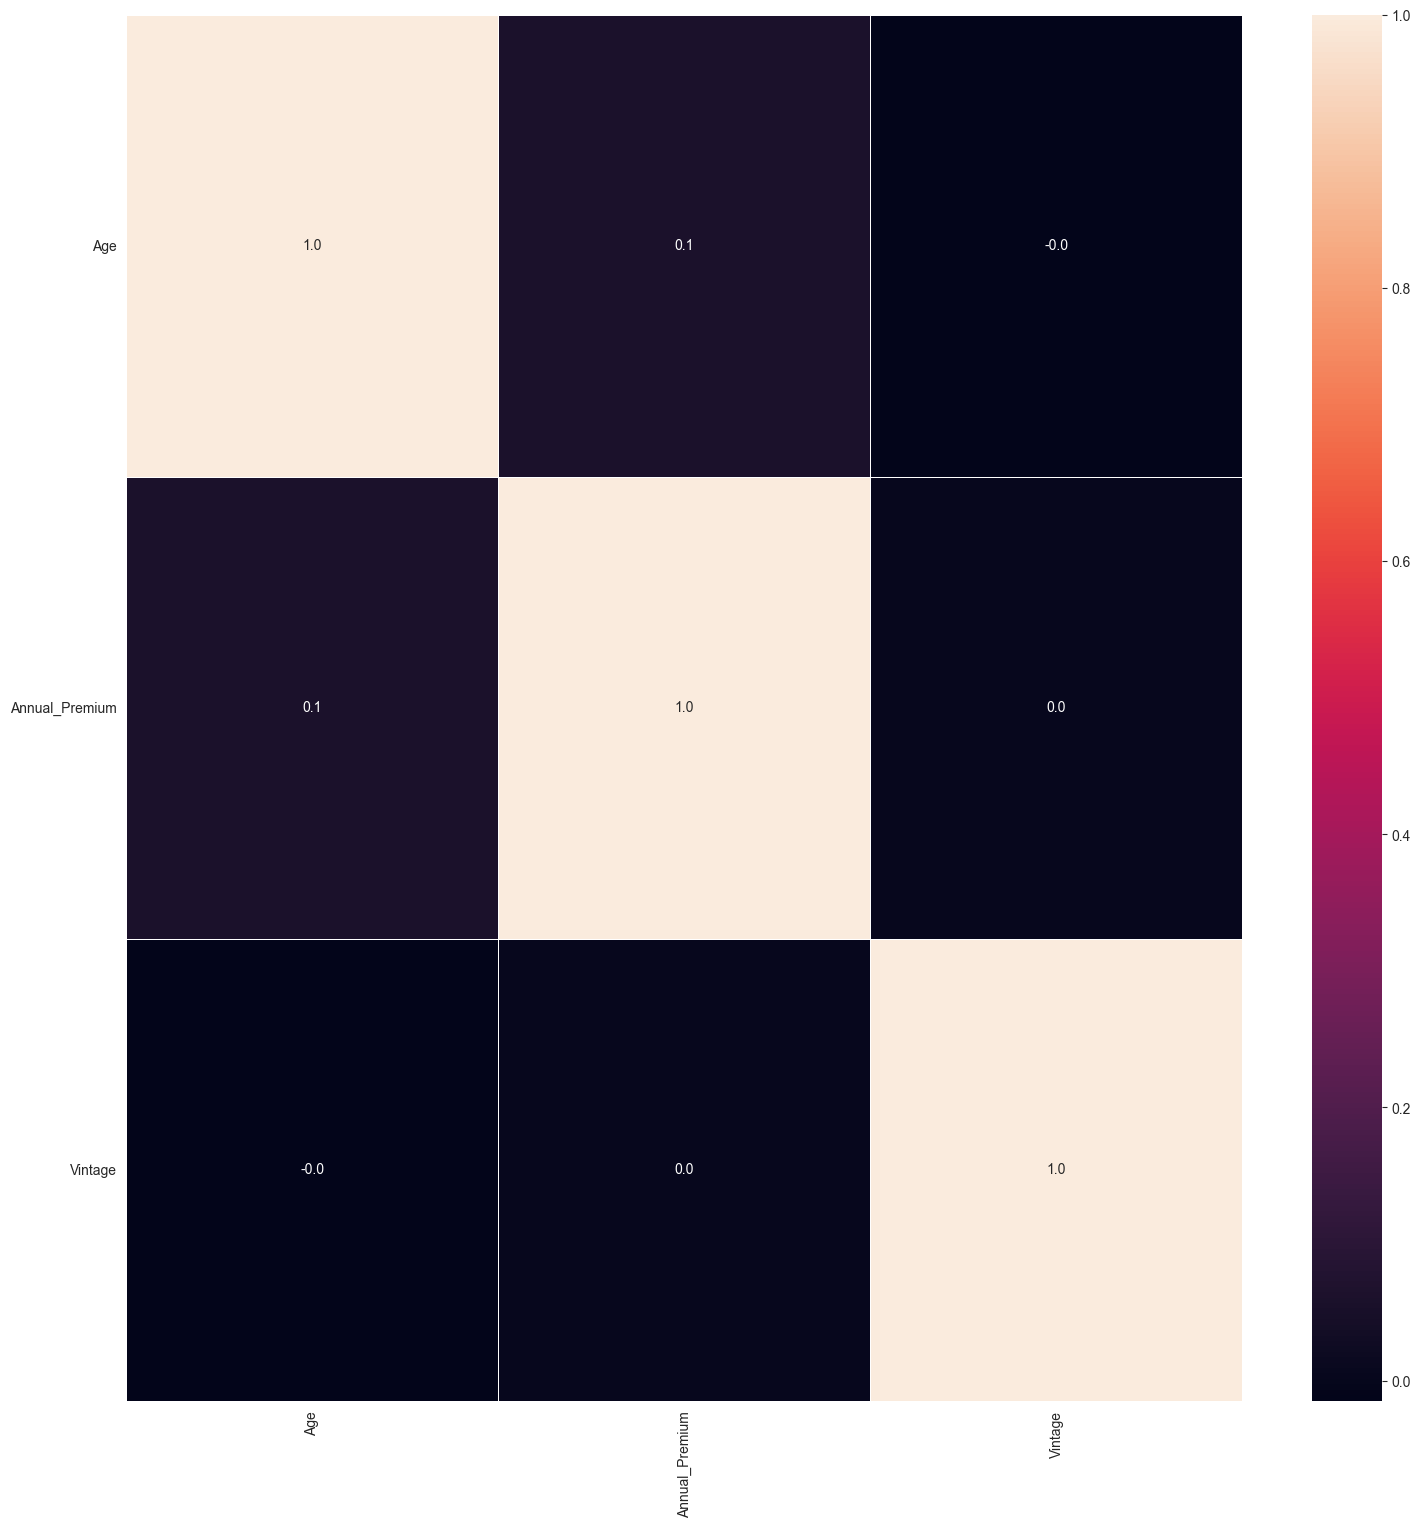

In [11]:
num_df = train_sample[["Age","Annual_Premium","Vintage"]]
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(num_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show()
plt.close("all")




## X, y split

In [12]:

from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

# drop id columns
train.drop(["id"],axis = 1, inplace = True)

# features
x_train = train.drop(["Response"], axis = 1)
# label
y_train = train.Response

X_data, X_valid, y_data,y_valid =  train_test_split(x_train, y_train, test_size=0.25,  random_state=42, stratify = y_train)

# sample split
train_sample.drop(["id"],axis = 1, inplace = True)

# features
xs_train = train_sample.drop(["Response"], axis = 1)
# label
ys_train = train_sample.Response

Xs_data, Xs_valid, ys_data,ys_valid =  train_test_split(xs_train, ys_train, test_size=0.25,  random_state=42, stratify = ys_train)


## Bivariate visualization

### Numerical 

#### Violin 

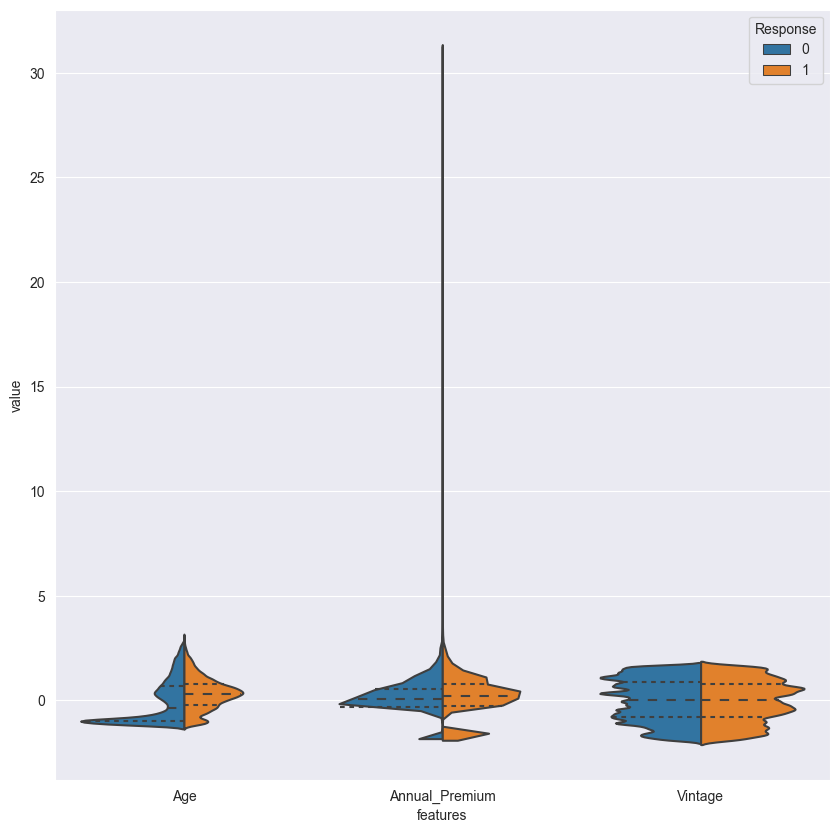

In [26]:
data_num = xs_train[["Age","Annual_Premium","Vintage"]]
data_n_2 = (data_num - data_num.mean()) / (data_num.std())              # standardization
data = pd.concat([ys_train,data_n_2.iloc[:,0:3]],axis=1)
data_long = pd.melt(data,id_vars="Response",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Response", data=data_long,split=True, inner="quart")
plt.xticks(rotation=0)
plt.show()
plt.close("all")

The outliers are making our plot very compressed. Let's view them separately to see the underlying distribution differences.

##### Outliers

In [30]:
data_outlier =  data[(data["Annual_Premium"]>3) | (data["Annual_Premium"]<-3)]
data_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 142 to 1149906
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Response        1693 non-null   int64  
 1   Age             1693 non-null   float64
 2   Annual_Premium  1693 non-null   float64
 3   Vintage         1693 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 66.1 KB


In [31]:
data_outlier

,Response,Age,Annual_Premium,Vintage
142,0,1.308418,3.812918,1.225872
411,1,1.775173,3.937544,-1.911973
2298,0,-1.092040,3.573440,-1.611940
2455,0,1.641814,3.086420,1.150864
4268,0,0.574944,3.024473,1.063354
...,...,...,...,...
1148209,1,-0.958682,3.364263,0.275768
1149020,0,-0.758644,3.108168,1.613414
1149553,0,1.241738,3.024473,1.325883
1149702,0,-1.092040,12.538162,1.025850


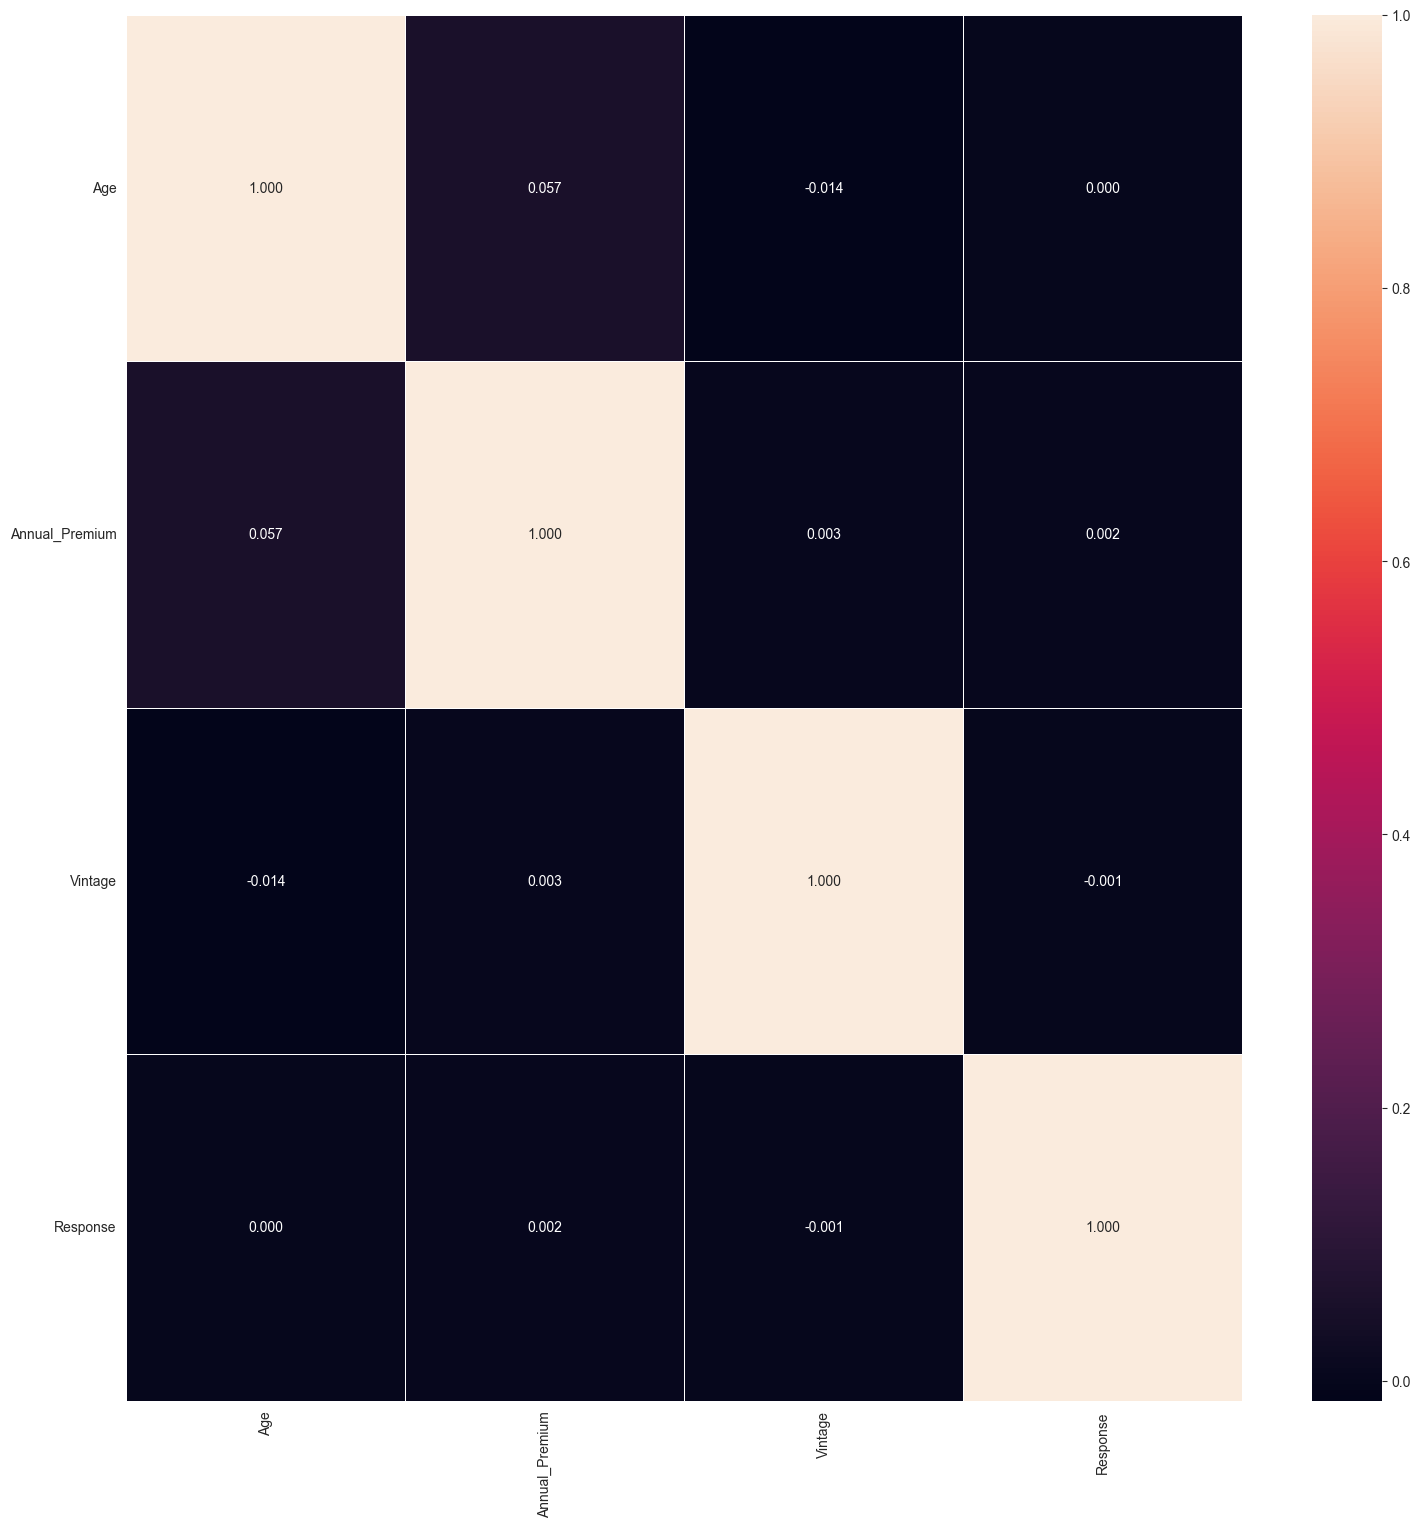

In [34]:
raw_data = pd.concat([Xs_data[["Age","Annual_Premium","Vintage"]],y_data],axis = 1)

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(raw_data.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)
# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show()
plt.close("all")

##### Remove outliers

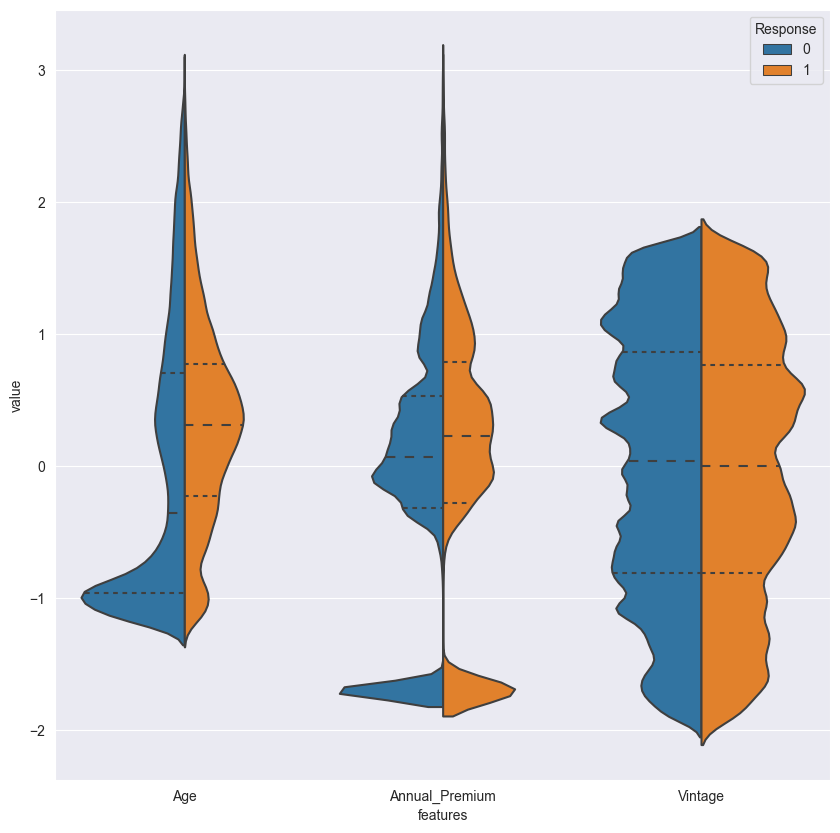

In [16]:
# remove outliers on 3 std 
data_removeoutlier =  data_long[(data_long["value"]<3) & (data_long["value"]>-3)]
data_removeoutlier.info
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Response", data=data_removeoutlier,split=True, inner="quart")
plt.xticks(rotation=0)
plt.show()
plt.close("all")


As we suspected from the univariate, Annual_premium contains some very large outliers. However, we also see that there appears to be a bimodal distribution with the extreme outliers removed. Another observation to make is that those that bought more services (cross sell - response variable) have age distributions centered past 0, whereas those that didn't appear to be much younger. My hunch is that those who are younger tend to have less disposable income to spare. Finally, the outlier group with extremely high Annual Premiums tended to be older. 

### Categorical

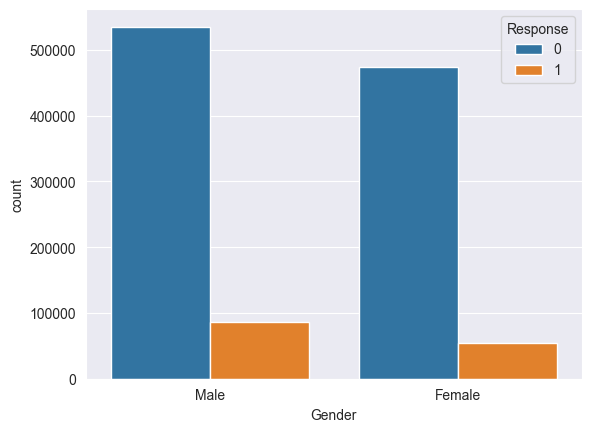

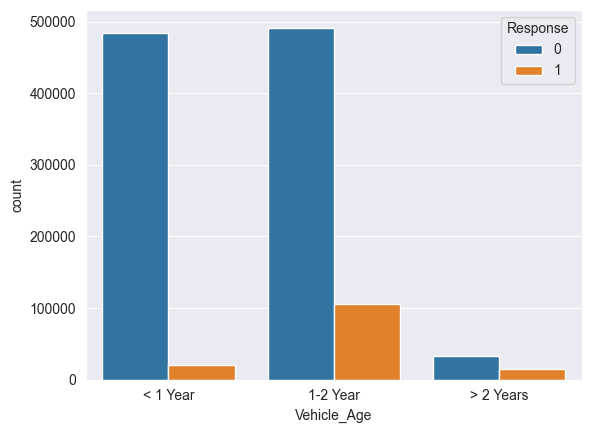

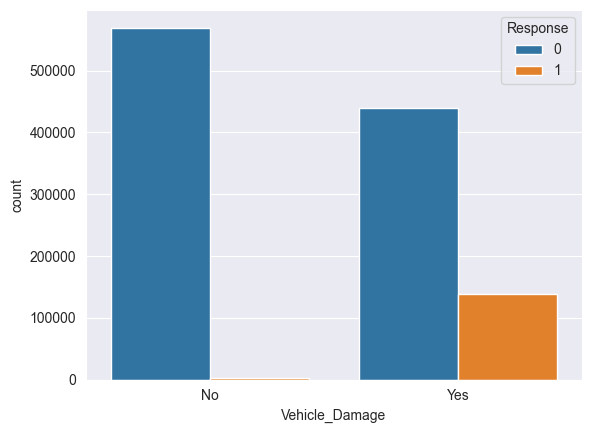

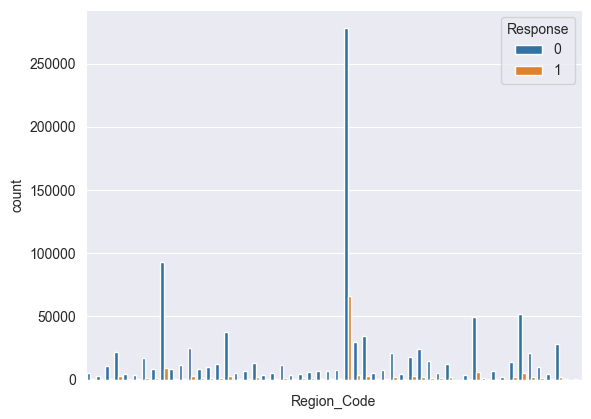

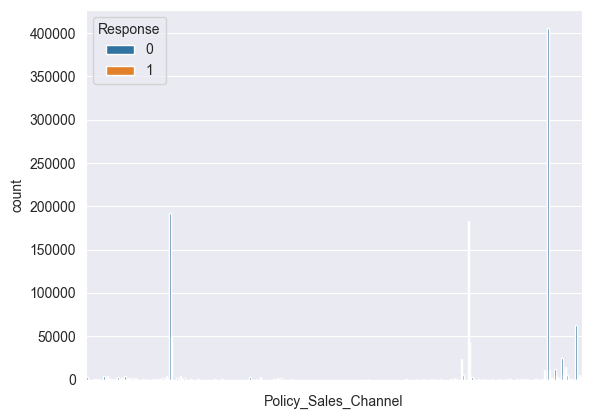

In [15]:
cat_data = pd.concat([ys_train,cat_df],axis=1)

for col in cat_df.columns:
    cat_compare = sns.countplot(cat_data, x=col, hue="Response")
    if col in ["Region_Code", "Policy_Sales_Channel"]: 
        cat_compare.set(xticklabels = [])
            
    plt.show()
    plt.close("all")


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from pandas.api.types import CategoricalDtype

# convert identified categorical types
for col in ['Policy_Sales_Channel','Region_Code']:
    X_data[col] = X_data[col].astype('category')

cat_dtype = CategoricalDtype(
    categories=['< 1 Year','1-2 Year','> 2 Years'], ordered=True)
X_data['Vehicle_Age'] = X_data['Vehicle_Age'].astype(cat_dtype)

# grab columns by type
nominal_col = train_sample.select_dtypes(include = ['category','object']).columns.drop("Vehicle_Age")
num_col = data_num.columns
ordered_col = ["Vehicle_Age"]

# numerical transformer
num_pipe = Pipeline(steps=[
    ("standardize", StandardScaler()) # standardize
])
# categorical transformer
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ord_pipe = Pipeline(steps=[
    ("ord", OrdinalEncoder())
])

preprocess = ColumnTransformer(
    transformers=[
        ("ordinal",ord_pipe, ordered_col ),
        ("numerical", num_pipe, num_col),
        ("categorical", cat_pipe, nominal_col),
    ],
    remainder = "passthrough"
)

# Model fit and evaluation

## Models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

lor = LogisticRegression(solver = "sag")
svc = SVC(kernel='sigmoid',gamma=0.1)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
bagg = BaggingClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
etc = ExtraTreesClassifier()
gra = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
dumb = DummyClassifier(strategy = 'most_frequent')

clfs = {
     'dumb': dumb,
     'lor':lor,
   #  'SVC':svc,
     'knn':knn,
     'dt':dt,
     'rf':rf,
     'bagg':bagg,
     'ada':ada,
     'etc':etc,
     'gra':gra,
     'xgb':xgb,
     'lgbm':lgbm
     
}

## Fit loop

In [21]:

from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score

def Train_Model(clf,x_train,y_train,x_test,y_test):
     
     pipeline = Pipeline(steps=[
          ('column_tran',preprocess),
          ('model',clf)
     ])

     pipeline.fit(x_train,y_train)
     y_pred = pipeline.predict(x_test)
     acc = accuracy_score(y_test,y_pred)
     ps = precision_score(y_test,y_pred)
     rec = recall_score(y_test,y_pred)
     f1 = f1_score(y_test,y_pred)
     return acc , ps ,rec, f1

## Fit models

In [22]:
from tqdm import tqdm

acc_score = []
pre_score = []
recall = []
f1s = []

for key,value in tqdm(clfs.items()):
     acc,ps,rs,f1 = Train_Model(value,Xs_data,ys_data,Xs_valid,ys_valid)

     print("name:",key)
     print('ac:',acc)
     print('ps :',ps)
     print('rs:',rs)
     print('f1:',f1)
     
     acc_score.append(acc)
     pre_score.append(ps)
     recall.append(rs)
     f1s.append(f1)

  0%|          | 0/11 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 1/11 [00:02<00:20,  2.09s/it]

name: dumb
ac: 0.8771608372157708
ps : 0.0
rs: 0.0
f1: 0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 2/11 [00:48<04:11, 27.92s/it]

name: lor
ac: 0.877146929977053
ps : 0.16666666666666666
rs: 2.8303755908409045e-05
f1: 5.659790021790192e-05


 27%|██▋       | 3/11 [02:20<07:37, 57.20s/it]

name: knn
ac: 0.858427786662958
ps : 0.36378804732531095
rs: 0.2036455237610031
f1: 0.26111887350523505


 36%|███▋      | 4/11 [02:28<04:25, 38.00s/it]

name: dt
ac: 0.829796258952785
ps : 0.31710657036221573
rs: 0.3342673572783108
f1: 0.3254609088654339


 45%|████▌     | 5/11 [06:29<11:07, 111.24s/it]

name: rf
ac: 0.867283220916487
ps : 0.40163423585624264
rs: 0.16416178426877245
f1: 0.23306276621393554


 55%|█████▍    | 6/11 [07:31<07:51, 94.24s/it] 

name: bagg
ac: 0.8642618733050553
ps : 0.38947807435653004
rs: 0.18502165237326992
f1: 0.2508682720905689


 64%|██████▎   | 7/11 [08:21<05:20, 80.02s/it]

name: ada
ac: 0.8770947778318615
ps : 0.4214876033057851
rs: 0.0014434915513288613
f1: 0.0028771296400767234


 73%|███████▎  | 8/11 [11:18<05:32, 110.86s/it]

name: etc
ac: 0.8616820805229122
ps : 0.3735658298307395
rs: 0.1861538026096063
f1: 0.2484840470748248


 82%|████████▏ | 9/11 [14:22<04:27, 133.59s/it]

name: gra
ac: 0.8771921285028857
ps : 0.5529411764705883
rs: 0.0013302765276952252
f1: 0.002654167607860854


 91%|█████████ | 10/11 [14:29<01:34, 94.53s/it]

name: xgb
ac: 0.8797927821431055
ps : 0.5696668507270385
rs: 0.08760012453652599
f1: 0.15184967127857912
[LightGBM] [Info] Number of positive: 105991, number of negative: 756868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 862859, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122837 -> initscore=-1.965835
[LightGBM] [Info] Start training from score -1.965835


100%|██████████| 11/11 [14:36<00:00, 79.70s/it]

name: lgbm
ac: 0.8791565259717683
ps : 0.5956666666666667
rs: 0.05057881180832696
f1: 0.09324045811484177


## Model evaluation

In [23]:
model_df = pd.DataFrame({'Algoritham':clfs.keys(),'Accuracy Score':acc_score,'Precision Score':pre_score,'Recall Score':recall,'F1 Score':f1s}).sort_values('Accuracy Score',ascending=False)
model_df

,Algoritham,Accuracy Score,Precision Score,Recall Score,F1 Score
9,xgb,0.879793,0.569667,0.087600,0.151850
10,lgbm,0.879157,0.595667,0.050579,0.093240
8,gra,0.877192,0.552941,0.001330,0.002654
0,dumb,0.877161,0.000000,0.000000,0.000000
1,lor,0.877147,0.166667,0.000028,0.000057
6,ada,0.877095,0.421488,0.001443,0.002877
4,rf,0.867283,0.401634,0.164162,0.233063
5,bagg,0.864262,0.389478,0.185022,0.250868
7,etc,0.861682,0.373566,0.186154,0.248484
2,knn,0.858428,0.363788,0.203646,0.261119


Based on accuracy alone, XGB stands out as the best model. We'll try using a voting classifier again as an initial model.

# Vote classifier

In [29]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[
     ('xgb',xgb),
     ('gra',gra),
     ('lgbm',lgbm)], voting = 'soft')
Train_Model(vote,Xs_data,ys_data,Xs_valid,ys_valid)

[LightGBM] [Info] Number of positive: 105991, number of negative: 756868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 862859, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122837 -> initscore=-1.965835
[LightGBM] [Info] Start training from score -1.965835


(0.8785898059940199,
 0.635822868473232,
 0.027228213183889502,
 0.0522201715340354)